In [591]:
# import all the required packages for the modelling
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [592]:
# Load data into a variable
sourceData = pd.read_csv('train.csv')
sourceData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [593]:
# total number of rows
sourceData.shape

(1460, 81)

In [594]:
# % of blank rows in the data column
sourceData.isnull().sum()[sourceData.isnull().sum() > 0]/1460*100

LotFrontage     17.739726
Alley           93.767123
MasVnrType      59.726027
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

In [595]:
# FillNa Values for Categorical Variables & Numeric Variables
def fillNaCategorical(dataframe,columnName):
    mode_value = dataframe[columnName].mode()[0]
    dataframe[columnName].fillna(mode_value,inplace = True)
    
def fillNaNumeric(dataframe,columnName):
    mode_value = dataframe[columnName].mean()[0]
    dataframe[columnName].fillna(mode_value,inplace = True)

In [596]:
#catDataType = pd.DataFrame(sourceData.dtypes)
for val in sourceData.select_dtypes(include = ['object']).columns.tolist():
    print(val)
    fillNaCategorical(sourceData,val)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [597]:
# function to drop the selected list of columns from the dataframe
def dropColumnsFromDF(dataframe,dropColumnList):
    dataframe = dataframe.drop(dropColumnList,axis = 1)
    return dataframe

In [598]:
dropColumnList = ['Alley','PoolQC','Fence','MiscFeature','Id','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','LowQualFinSF','BsmtFinSF2']
# ['EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','SalePrice'] dropped as it does not have any corr
# LowQualFinSF, BsmtFinSF2 has value more than 0 for only < 12% of the data
sourceData = dropColumnsFromDF(sourceData,dropColumnList)

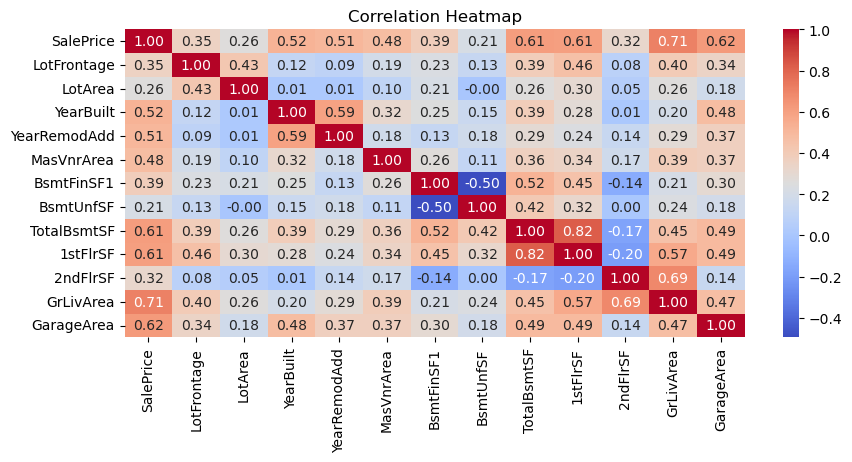

In [599]:
correlation_matrix = sourceData[['SalePrice','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea']].corr()
# Plot the correlation heatmap
plt.figure(figsize=(10, 4))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

1stFlrSF is 82% correlated with Total BasementSF and both are 61% Correlated with Target Variable. Hence Dropping 1stFlrSF

In [600]:
dropColumnList = ['1stFlrSF']
sourceData = dropColumnsFromDF(sourceData,dropColumnList)

In [601]:
sourceData['YrSold'].unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


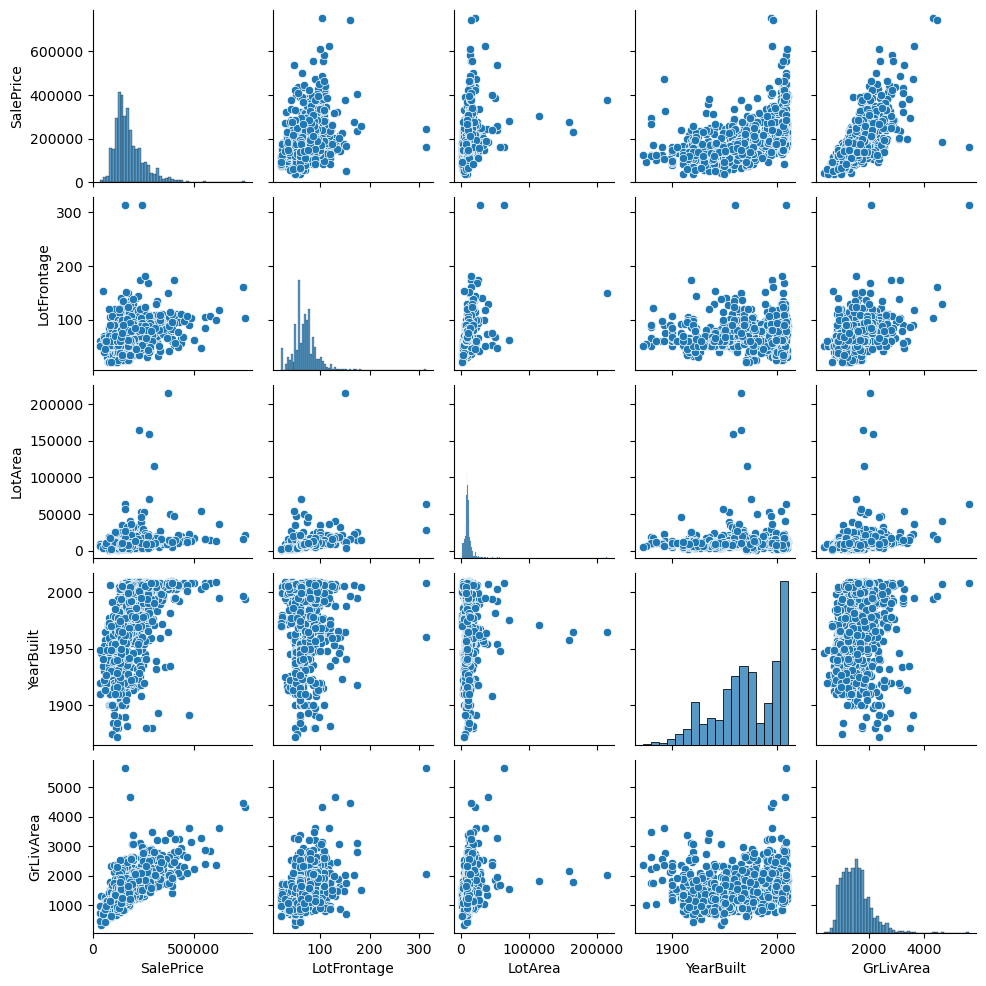

In [602]:
# pairplot with hue sex 
pair_grid = sns.pairplot(sourceData[['SalePrice','LotFrontage','LotArea','YearBuilt','GrLivArea']], kind = 'scatter',height = 2, dropna = True) 
plt.show()


In [603]:
import numpy as np

# Assuming data is a NumPy array or a list
#data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 100])  # Introducing an outlier (100)
data = sourceData['LotArea']
# Calculate quartiles and IQR
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = (data < lower_bound) | (data > upper_bound)


print("First Quartile (Q1):", Q1)
print("Third Quartile (Q3):", Q3)
print("Interquartile Range (IQR):", IQR)
print("Lower bound for outliers:", lower_bound)
print("Upper bound for outliers:", upper_bound)

First Quartile (Q1): 7553.5
Third Quartile (Q3): 11601.5
Interquartile Range (IQR): 4048.0
Lower bound for outliers: 1481.5
Upper bound for outliers: 17673.5


In [604]:
sourceData.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,61,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,TA,Y,298,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,42,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,TA,Y,0,35,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,TA,Y,192,84,0,12,2008,WD,Normal,250000


### Create Box Plot with categorical variables 
To understand the association of a categorical variable
- MSZoning seems to have a correlation with the Outcome variable. As for different values of the Outcome variable, there are Median is different
- *LandSlope* has no major changes in the Median of the box plots and can be dropped also the P-Value for ANOVA is more than 0.05
- *Utilities* have same value as AllPub across and hence can be dropped

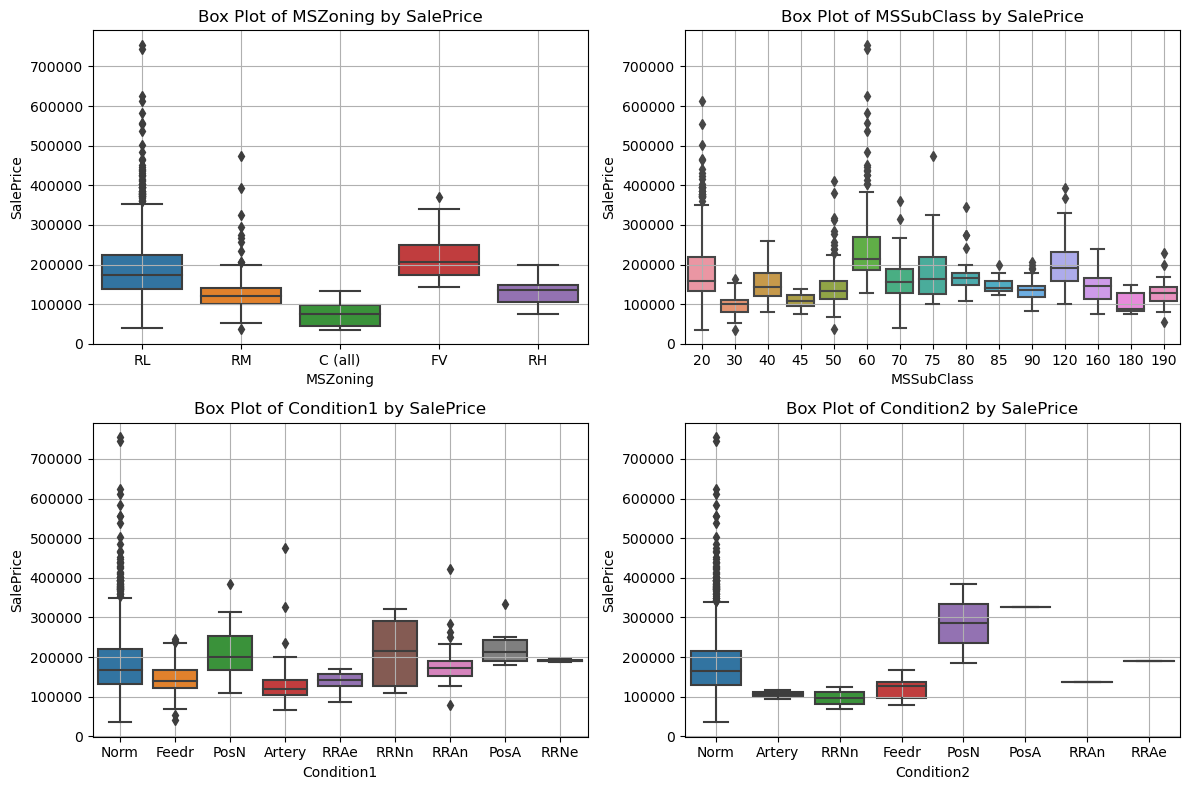

In [605]:
# Box plot using Seaborn
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
sns.boxplot(x='MSZoning', y='SalePrice', data=sourceData)
plt.xlabel('MSZoning')
plt.ylabel('SalePrice')
plt.title('Box Plot of MSZoning by SalePrice')
plt.grid(True)

plt.subplot(2,2,2)
sns.boxplot(x='MSSubClass', y='SalePrice', data=sourceData)
plt.xlabel('MSSubClass')
plt.ylabel('SalePrice')
plt.title('Box Plot of MSSubClass by SalePrice')
plt.grid(True)

plt.subplot(2,2,3)
sns.boxplot(x='Condition1', y='SalePrice', data=sourceData)
plt.xlabel('Condition1')
plt.ylabel('SalePrice')
plt.title('Box Plot of Condition1 by SalePrice')
plt.grid(True)

plt.subplot(2,2,4)
sns.boxplot(x='Condition2', y='SalePrice', data=sourceData)
plt.xlabel('Condition2')
plt.ylabel('SalePrice')
plt.title('Box Plot of Condition2 by SalePrice')
plt.grid(True)

plt.tight_layout()
plt.show()

In [606]:
sourceData[sourceData['Utilities'] == 'AllPub']

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,61,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,TA,Y,298,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,42,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,TA,Y,0,35,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,TA,Y,192,84,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,40,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,349,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,60,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,366,0,0,4,2010,WD,Normal,142125


In [607]:
# Perform analysis for Categorical Variable Impact on Outcome Variable using ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

data = sourceData[['Condition1','SalePrice']]

# Fit the model
model = ols('SalePrice ~ Condition1', data=data).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Print ANOVA table
print(anova_table)

# Interpret results
alpha = 0.05
p_value = anova_table['PR(>F)']['Condition1']
print("P Value is: ", p_value)
if p_value < alpha:
    print("Reject the null hypothesis. There are significant differences between group means.")
else:
    print("Fail to reject the null hypothesis. There are no significant differences between group means.")

                  sum_sq      df         F        PR(>F)
Condition1  3.004600e+11     8.0  6.118017  8.904549e-08
Residual    8.907451e+12  1451.0       NaN           NaN
P Value is:  8.904549416140846e-08
Reject the null hypothesis. There are significant differences between group means.


In [608]:
# impute numeric values with mean wherver null
sourceData['LotFrontage'].fillna(sourceData['LotFrontage'].mean(),inplace = True)
sourceData['MasVnrArea'].fillna(sourceData['MasVnrArea'].mean(),inplace = True)
sourceData['GarageYrBlt'].fillna(sourceData['GarageYrBlt'].max(),inplace = True)

In [609]:
# Perform Ordinal Encoding for Ordinal Categorical Variables:

from sklearn.preprocessing import OrdinalEncoder

Ordinaldata = sourceData[['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']]
# Define custom mapping
mapping = {'Ex': 1, 'Gd': 2, 'TA': 3,'Fa':4,'Po':5}

for col in Ordinaldata.columns:
    sourceData[col] = sourceData[col].replace(mapping)


In [610]:
sourceData['Exterior1st'].unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

In [611]:
def rating_mapper1(x):
    return x.map({'Gd': 4, "Av": 3, "Mn": 2, "No": 1, "None": 0})

def house_status_mapper(x):
    return x.map({'Fin': 3, "RFn": 2, "Unf": 1, "None": 0})

def rating_mapper2(x):
    return x.map({'GLQ': 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, 'Unf': 1, 'None': 0})

def MSZoning(x):
    return x.map({'A': 6, "C (all)": 5, "FV": 4, "I": 3, "RH": 2, "RL": 1, "RP": 0,"RM":7})

def street(x):
    return x.map({'Grvl': 0, "Pave": 1, "NA": 2})

def condition(x):
    return x.map({'Artery':0,'Feedr':1,'Norm':2,'RRNn':3,'RRAn':4,'PosN':5,'PosA':6,'RRNe':7,'RRAe':8})

def exterior(x):
    return x.map({'VinylSd':0,'MetalSd':1,'Wd Shng':2,'HdBoard':3,'Plywood':4,'Wd Sdng':5,'CmentBd':6,'CemntBd':6,'BrkFace':7,'Stucco':8,'AsbShng':9,'Brk Cmn':10,'BrkComm':10, 'ImStucc':11,'AsphShn':12,'Stone':13, 'Other':14, 'CBlock':15,'WdShing':16})

def CentralAir(x):
    return x.map({'N':0,'Y':1})

sourceData[['BsmtExposure']] = sourceData[['BsmtExposure']].apply(rating_mapper1)
sourceData[['BsmtFinType1', 'BsmtFinType2']] = sourceData[['BsmtFinType1', 'BsmtFinType2']].apply(rating_mapper2)
sourceData[['GarageFinish']] = sourceData[['GarageFinish']].apply(house_status_mapper)
sourceData[['Street']] = sourceData[['Street']].apply(street)
sourceData[['MSZoning']] = sourceData[['MSZoning']].apply(MSZoning)
sourceData[['Condition1','Condition2']] = sourceData[['Condition1','Condition2']].apply(condition)
sourceData[['Exterior1st']] = sourceData[['Exterior1st']].apply(exterior)
sourceData[['Exterior2nd']] = sourceData[['Exterior2nd']].apply(exterior)
sourceData[['CentralAir']] = sourceData[['CentralAir']].apply(CentralAir)

In [612]:
sourceData.isnull().sum()[sourceData.isnull().sum() > 0]

Series([], dtype: int64)

In [613]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Encode categorical columns
for col in sourceData[['SaleCondition','SaleType','PavedDrive','GarageType','Functional','Electrical','Heating','Foundation','MasVnrType','RoofMatl','RoofStyle','HouseStyle','BldgType','Neighborhood','LandSlope','LotConfig','Utilities','LandContour','LotShape','MSZoning']].columns:
    sourceData[col] = label_encoder.fit_transform(sourceData[col])

In [614]:
# Classify variables into X & Y (i.e; predictors and target variables)

y = sourceData['SalePrice']
sourceData.drop(['SalePrice'],axis = 1, inplace = True)
X = sourceData

In [615]:
#Scale Data to bring to a single scale for predictions

from sklearn.preprocessing import StandardScaler
# Initialize StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.073375,-0.492473,-0.229372,-0.207142,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,...,-0.096397,-0.105926,0.289745,-0.752176,0.216503,-0.087688,-1.599111,0.138777,0.313867,0.208502
1,-0.872563,-0.492473,0.451936,-0.091886,0.064238,0.750731,0.314667,-0.02618,-0.628316,-0.225716,...,-0.096397,-0.105926,0.289745,1.626195,-0.704483,-0.087688,-0.489110,-0.614439,0.313867,0.208502
2,0.073375,-0.492473,-0.093110,0.073480,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,...,-0.096397,-0.105926,0.289745,-0.752176,-0.070361,-0.087688,0.990891,0.138777,0.313867,0.208502
3,0.309859,-0.492473,-0.456474,-0.096897,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,...,-0.096397,-0.105926,0.289745,-0.752176,-0.176048,-0.087688,-1.599111,-1.367655,0.313867,-3.426284
4,0.073375,-0.492473,0.633618,0.375148,0.064238,-1.378933,0.314667,-0.02618,-0.628316,-0.225716,...,-0.096397,-0.105926,0.289745,0.780197,0.563760,-0.087688,2.100892,0.138777,0.313867,0.208502


In [616]:
# split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [617]:
# Create a simple linear regression mocel to check the outputs

from sklearn.linear_model import LinearRegression,Ridge, Lasso
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# fit the model using train data
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train,y_pred_train)
print("R-Squared Data on the Training Set is: ",r2_train)

R-Squared Data on the Training Set is:  0.8431197074832543


In [618]:
# Model coefficient & intercept:
print(model.intercept_)
print(model.coef_)

180318.5867373795
[-7690.58302593 -2394.76012814 -2774.54981247  2087.26686644
   898.52347994  -507.16868737  3858.57724346 -1092.96602945
   288.54072843  2947.92956337  4107.19308112 -1004.69853111
 -3972.7423413  -1016.68847696 -4132.59194225 15736.15676685
  5698.06850519   487.34856776   108.13235381  2246.89544246
  3493.68063171 -2737.15903598  2496.63919491  -445.49451459
  5547.46240522 -4561.93696996   861.14909456  2104.87524038
 -8610.1096213    312.654421    7829.84373742  4568.82515991
 -1229.60629132  -226.75632886  -617.97604016  2834.25455664
  -232.47366018  -782.80406484 -1156.8347378   -196.2186847
  2237.47934329 22427.10999649  4025.88305927   309.81057908
  2876.79934981  1559.31839439 -2010.1720836  -2085.25807812
 -5919.80626199  3767.15996322  2710.15070936  5692.03222852
 -4210.15796325 -1296.09724733  1152.42525136  1261.81626543
  6808.16157826   165.26244678 -2258.32977832   993.38549842
  -391.33651531   638.54256602  -602.01055227   792.4688297
  -217.2

In [619]:
# Metrics to assess model performance 
rss = np.sum(np.square(y_train - y_pred_train)) # sum of the squared difference between the actual and the predicted values
print("RSS Value for Training Data: ",rss)
mse = mean_squared_error(y_train, y_pred_train) # MSE is RSS divided by the number of observations
print("MSE value for training data: ",mse)
rmse = mse**0.5 # RMSE is square root of MSE 
print("RMSE value for traning data: ",rmse)

RSS Value for Training Data:  1001005894123.2107
MSE value for training data:  980417134.3028508
RMSE value for traning data:  31311.61340945003


In [620]:
y_pred_test = model.predict(X_test)
r2_train = r2_score(y_test,y_pred_test)
print("R-Squared Data on the Test Set is: ",r2_train)

R-Squared Data on the Test Set is:  0.8332692514606055


### Checking for Linear Regression Assumptions

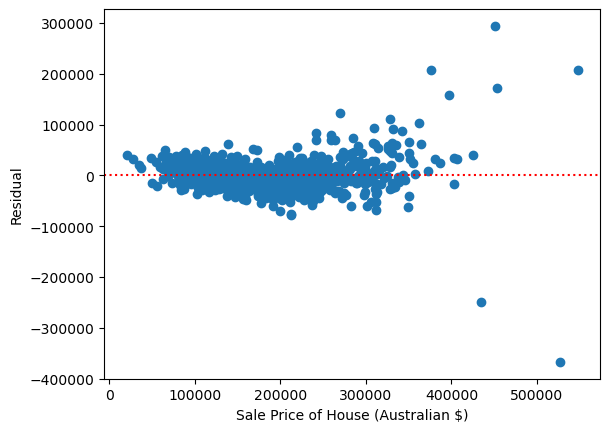

In [621]:
# Residual analysis
y_res = y_train - y_pred_train # Residuals
# Residual v/s predictions plot
#data = pd.DataFrame(y_res,columns = ['res'])
#print(data['res'])
plt.scatter(y_pred_train , y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Sale Price of House (Australian $)")
plt.ylabel("Residual")
plt.show()

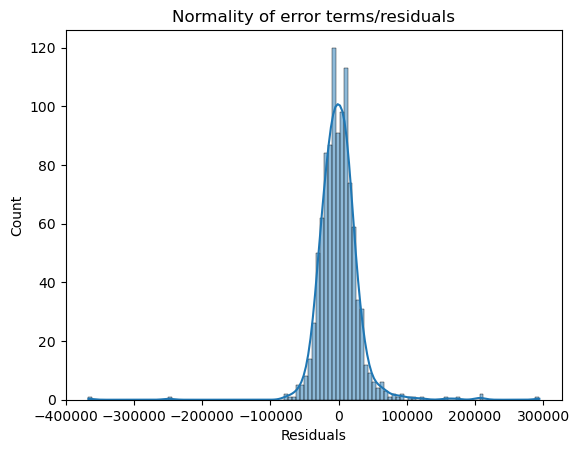

In [622]:
# Normality test of residuals

# Distribution of errors
p = sns.histplot(y_res,kde=True)

p = plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

### The linear regression equation hold for the given data set

## Ridge Regression

In [623]:
# list of alphas to tune
list_alpha = [0.1, 0.5, 1.0, 5.0, 20, 
 40, 70, 100, 150, 200, 250, 300, 350, 400, 450, 500, 
 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
params = {'alpha': list_alpha}

ridge = Ridge()

# cross validation
folds = 5
model = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model.fit(X_train, y_train) 

Fitting 5 folds for each of 26 candidates, totalling 130 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 5.0, 20, 40, 70, 100, 150,
                                   200, 250, 300, 350, 400, 450, 500, 550, 600,
                                   650, 700, 750, 800, 850, 900, 950, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [624]:
# Checking best parameter (alpha)
alpha = model.best_params_['alpha']

In [625]:
# Fit the model using the best alpha using Grid Search CV
ridge = Ridge(alpha = alpha)
ridge.fit(X_train, y_train)
ridge.coef_

array([-3.09190205e+03, -1.61050521e+03,  1.39908982e+02,  2.24114868e+03,
        7.84006997e+02, -1.25584364e+03,  1.52335825e+03, -7.42683656e+02,
       -3.80909871e+01,  1.79417100e+03,  2.87097250e+03, -5.89486378e+02,
       -2.20436363e+03, -2.07614366e+03, -2.19868903e+03,  1.03285283e+04,
        2.75491702e+03,  8.40225412e+02,  2.29704359e+03,  2.49117116e+03,
        3.32157544e+03, -3.63655470e+02,  8.91192669e+02,  5.97625798e+02,
        5.01458911e+03, -5.49376422e+03,  2.53731196e+02,  1.85855190e+03,
       -6.05762632e+03, -3.20659602e+02,  5.25775178e+03,  3.01801729e+03,
        2.73807454e+03,  3.97202426e+02,  1.57542665e+03,  4.94888357e+03,
        2.24862938e+02, -1.73513586e+03, -1.49427326e+02, -4.77728458e+01,
        4.48645251e+03,  9.60086019e+03,  2.56363856e+03,  1.28161298e+02,
        3.94152341e+03,  2.14642864e+03,  6.25766237e+00, -2.00443466e+03,
       -5.98168007e+03,  5.10510503e+03,  1.89929548e+03,  5.49244226e+03,
       -2.89687411e+03, -

In [626]:
y_pred_ridge = ridge.predict(X_train)

# R Square number from Ridge Regression:

r2_train = r2_score(y_train,y_pred_ridge)
print("R-Squared Data on the Training Set for Ridge Regression is: ",r2_train)

R-Squared Data on the Training Set for Ridge Regression is:  0.8275763070669824


In [627]:
y_pred = ridge.predict(X_test)

# R Square number from Ridge Regression:

r2_train = r2_score(y_test,y_pred)
print("R-Squared Data on the Testing Set for Ridge Regression is: ",r2_train)

R-Squared Data on the Testing Set for Ridge Regression is:  0.8313513730283658


In [628]:
def topPredictors(dataframe,coefficients):
    feature_name = dataframe.columns
    coefficient_dict = dict(zip(feature_name,coefficients))
    #print(coefficient_dict)
    sorted_coefficient = sorted(coefficient_dict.items(),key = lambda x: abs(x[1]), reverse = True)
    return sorted_coefficient[:10]

In [629]:
# Top 10 predictors
topPredictors(X_train,ridge.coef_)

[('OverallQual', 10328.528284973647),
 ('GrLivArea', 9600.86018941837),
 ('BsmtQual', -6057.626315395912),
 ('KitchenQual', -5981.680065432037),
 ('ExterQual', -5493.76421796902),
 ('Fireplaces', 5492.44226062039),
 ('BsmtExposure', 5257.7517807344875),
 ('TotRmsAbvGrd', 5105.105032083736),
 ('MasVnrArea', 5014.589114945636),
 ('TotalBsmtSF', 4948.883567844711)]

#### Not much difference in the testing and training R Squared Data

### Lasso Regression

In [630]:
# list of alphas to tune
list_alpha = [0.1, 0.5, 1.0, 5.0, 20, 
 40, 70, 100, 150, 200, 250, 300, 350, 400, 450, 500, 
 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
params = {'alpha': list_alpha}

lasso = Lasso()

# cross validation
folds = 5
model = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model.fit(X_train, y_train) 

Fitting 5 folds for each of 26 candidates, totalling 130 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 5.0, 20, 40, 70, 100, 150,
                                   200, 250, 300, 350, 400, 450, 500, 550, 600,
                                   650, 700, 750, 800, 850, 900, 950, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [631]:
# Checking best parameter (alpha)
alpha = model.best_params_['alpha']

In [632]:
# Fit the model using the best alpha using Grid Search CV
lasso = Lasso(alpha = alpha)
lasso.fit(X_train, y_train)
lasso.coef_

array([-6806.5153722 , -1945.29361969,    -0.        ,  1701.26590526,
           0.        ,  -150.66677998,  2344.09643056,  -482.51205085,
           0.        ,  1900.87435325,  2605.4785127 ,    -0.        ,
       -2418.47478944,    -0.        , -1814.63692907, 17447.07451179,
        3109.81201994,     0.        ,   402.79156346,  1263.95784698,
        2293.0586063 ,  -159.60552244,     0.        ,     0.        ,
        4740.85175837, -5316.94306632,     0.        ,   723.03593264,
       -8671.11300109,    -0.        ,  6789.98293492,  4158.04049053,
           0.        ,     0.        ,     0.        ,   932.70916083,
          -0.        ,  -785.4595895 ,     0.        ,     0.        ,
           0.        , 25412.80596463,  2772.30651028,     0.        ,
         669.3890887 ,    77.81910926,    -0.        ,  -642.6458768 ,
       -6245.49016931,   181.75566496,  1771.2892194 ,  4414.27379254,
       -2299.95695054,  -771.30735072,   461.69804539,  1443.64942001,
      

In [633]:
y_pred_lasso = lasso.predict(X_train)

# R Square number from Ridge Regression:

r2_train = r2_score(y_train,y_pred_lasso)
print("R-Squared Data on the Training Set for Lasso Regression is: ",r2_train)

R-Squared Data on the Training Set for Lasso Regression is:  0.8361322608039405


In [634]:
y_pred = lasso.predict(X_test)

# R Square number from Ridge Regression:

r2_train = r2_score(y_test,y_pred)
print("R-Squared Data on the Testing Set for Ridge Regression is: ",r2_train)

R-Squared Data on the Testing Set for Ridge Regression is:  0.8352481126192842


In [635]:
# Top 10 predictors
topPredictors(X_train,lasso.coef_)

[('GrLivArea', 25412.805964631338),
 ('OverallQual', 17447.0745117861),
 ('BsmtQual', -8671.11300108841),
 ('MSSubClass', -6806.515372195433),
 ('BsmtExposure', 6789.982934920226),
 ('GarageCars', 6573.6303213469855),
 ('KitchenQual', -6245.490169314235),
 ('ExterQual', -5316.943066316331),
 ('MasVnrArea', 4740.851758368515),
 ('Fireplaces', 4414.273792536577)]